# PROJEKT R: Testiranje modela višestruke linearne regresije

**Student:** Igor Vuković
**Kolegij:** Projekt R
**Tema:** Predviđanje kretanja cijena dionica

## 1. Uvod i Cilj
Cilj ove faze projekta je testirati i evaluirati model linearne regresije za predviđanje cijene dionice tvrtke **Apple Inc. (AAPL)**.
Model koristi pristup **autoregresije**, gdje se buduća cijena (`Close`) predviđa na temelju povijesnih vrijednosti cijene i volumena trgovanja.

U ovom dokumentu ćemo:
1.  Dohvatiti i pripremiti podatke.
2.  Analizirati korelacije među varijablama.
3.  Trenirati model na povijesnim podacima (2020. - 2023.).
4.  Evaluirati točnost modela na neviđenim podacima (kraj 2023. - 2024.).
5.  Analizirati značajke i ograničenja modela.


In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Postavke prikaza
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8') # Ili 'ggplot' ako seaborn ne radi

# 1. DOHVAT PODATAKA
# Koristimo fiksni ticker za potrebe izvještaja i reprodukcije rezultata
ticker = "AAPL"
print(f"Dohvaćanje podataka za: {ticker}...")
data = yf.download(ticker, start="2020-01-01", end="2025-01-01")

if data.empty:
    print("Greška: Nema podataka za zadani simbol.")
else:
    print(f"Podaci uspješno dohvaćeni. Ukupno dana: {len(data)}")

# 2. ČIŠĆENJE PODATAKA (Sanitization)
data.dropna(inplace=True)
data.sort_index(inplace=True)

# Provjera strukture
print("-" * 30)
print("Pregled prvih 5 redova:")
print(data.head())
print("\nInformacije o tipovima podataka:")
print(data.info())

# 3. PRIPREMA ZNAČAJKI (Feature Engineering)
# Kreiramo 'lag' varijable - pomičemo podatke kako bi model učio iz prošlosti
# Close_Lag1: Cijena zatvaranja jučer
# Close_Lag2: Cijena zatvaranja prekjučer
# Volume_Lag1: Volumen trgovanja jučer

data['Close_Lag1'] = data['Close'].shift(1)
data['Close_Lag2'] = data['Close'].shift(2)
data['Volume_Lag1'] = data['Volume'].shift(1)

# Nakon shiftanja, prvi redovi će imati NaN vrijednosti, pa ih mičemo
data.dropna(inplace=True)

# Definiranje ulaznih (X) i izlaznih (y) varijabli
independent_vars = data[['Close_Lag1', 'Close_Lag2', 'Volume_Lag1']].values
dependent_var = data['Close'].values
dates = data.index

# 4. PODJELA NA TRENING I TEST SET
split_idx = int(len(data) * 0.75)

x_train = independent_vars[:split_idx]
x_test = independent_vars[split_idx:]
y_train = dependent_var[:split_idx]
y_test = dependent_var[split_idx:]

train_dates = dates[:split_idx]
test_dates = dates[split_idx:]

# Pretvorba u numpy nizove za sklearn
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

print("-" * 30)
print(f"Period treniranja: {train_dates[0].date()} do {train_dates[-1].date()}")
print(f"Period testiranja: {test_dates[0].date()} do {test_dates[-1].date()}")

# 5. TRENIRANJE MODELA
model = LinearRegression()
model.fit(x_train, y_train)

# Generiranje predikcija za testni set
prediction = model.predict(x_test)

# Kreiranje DataFrame-a za lakšu usporedbu
comparison = pd.DataFrame(
    {"Actual": y_test, "Predicted": prediction},
    index=test_dates
)

print("\nModel je uspješno treniran i predikcije su generirane.")


/tmp/ipython-input-718848085.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Dohvaćanje podataka za: AAPL...
Podaci uspješno dohvaćeni. Ukupno dana: 1258
------------------------------
Pregled prvih 5 redova:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.468262  72.528582  71.223259  71.476600  135480400
2020-01-03  71.763725  72.523754  71.539337  71.696167  146322800
2020-01-06  72.335556  72.374162  70.634539  70.885472  118387200
2020-01-07  71.995361  72.600968  71.775796  72.345212  108872000
2020-01-08  73.153473  73.455072  71.698559  71.698559  132079200

Informacije o tipovima podataka:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2020-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1258 non-null   float64
 1   (High, AAPL)    1258 non-null   float64
 2

## 2. Eksploratorna Analiza Podataka (EDA)

Prije evaluacije modela, analiziramo odnose između varijabli pomoću korelacijske matrice.
Cilj je potvrditi linearnu povezanost između nezavisnih varijabli (ulaznih značajki) i zavisne varijable (cilj: `Close`).

**1. Korelacijska matrica (Heatmap):**  
Na grafu ispod prikazujemo jačinu linearne veze (od -1 do 1).
* **1.0 (Crveno):** Savršena pozitivna korelacija.
* **-1.0 (Plavo):** Savršena negativna korelacija.
* **0:** Nema linearne povezanosti.

**2. Pairplot:**  
Prikazuje dijagrame raspršenja (*scatter plots*) za vizualnu potvrdu linearnosti.

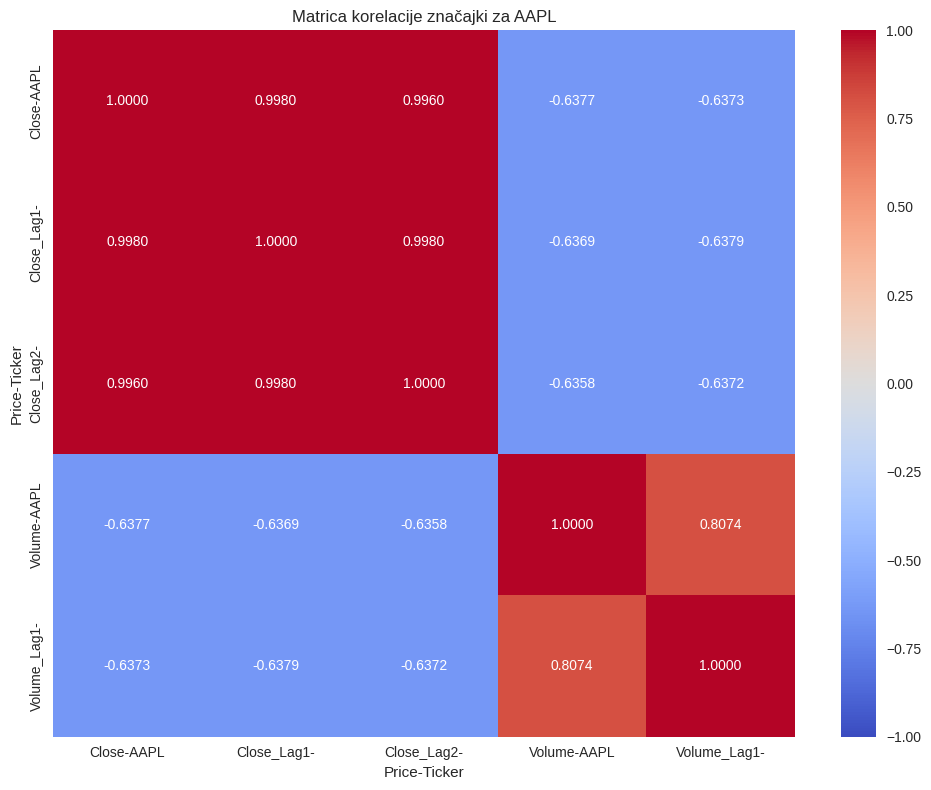

In [16]:
# Brišemo Open, High, Low jer ih ne koristimo kao ulaz u model, da matrica bude čišća
features_to_analyze = ['Close', 'Close_Lag1', 'Close_Lag2', 'Volume', 'Volume_Lag1']
correlation_data = data[features_to_analyze]

# 1. HEATMAP (Korelacijska matrica)
plt.figure(figsize=(10, 8))
corr_matrix = correlation_data.corr()

sns.heatmap(corr_matrix,
            annot=True,
            fmt='.4f',
            cmap='coolwarm',
            vmin=-1, vmax=1)

plt.title(f'Matrica korelacije značajki za {ticker}')
plt.tight_layout()
plt.show()


### Analiza korelacija:
Kao što možemo vidjeti na gornjem prikazu:
*   **Visoka korelacija cijena:** Varijable `Close_Lag1` i `Close_Lag2` imaju korelaciju gotovo **1.0** s trenutnom cijenom (`Close`). To potvrđuje našu pretpostavku da je jučerašnja cijena izvrstan prediktor današnje cijene u linearnom modelu.
*   **Slabija korelacija volumena:** Varijabla `Volume` i `Volume_Lag1` prikazane su plavom bojom (negativna ili slaba korelacija). Iako volumen nosi informacije o aktivnosti na tržištu, on nema jednostavnu linearnu vezu s razinom cijene (npr. visok volumen ne znači nužno visoku cijenu). Zbog kompleksnosti odnosa volumena i cijene, u ovom se izvještaju nećemo dublje baviti tom varijablom, ali je zadržavamo u modelu kao dodatni signal.


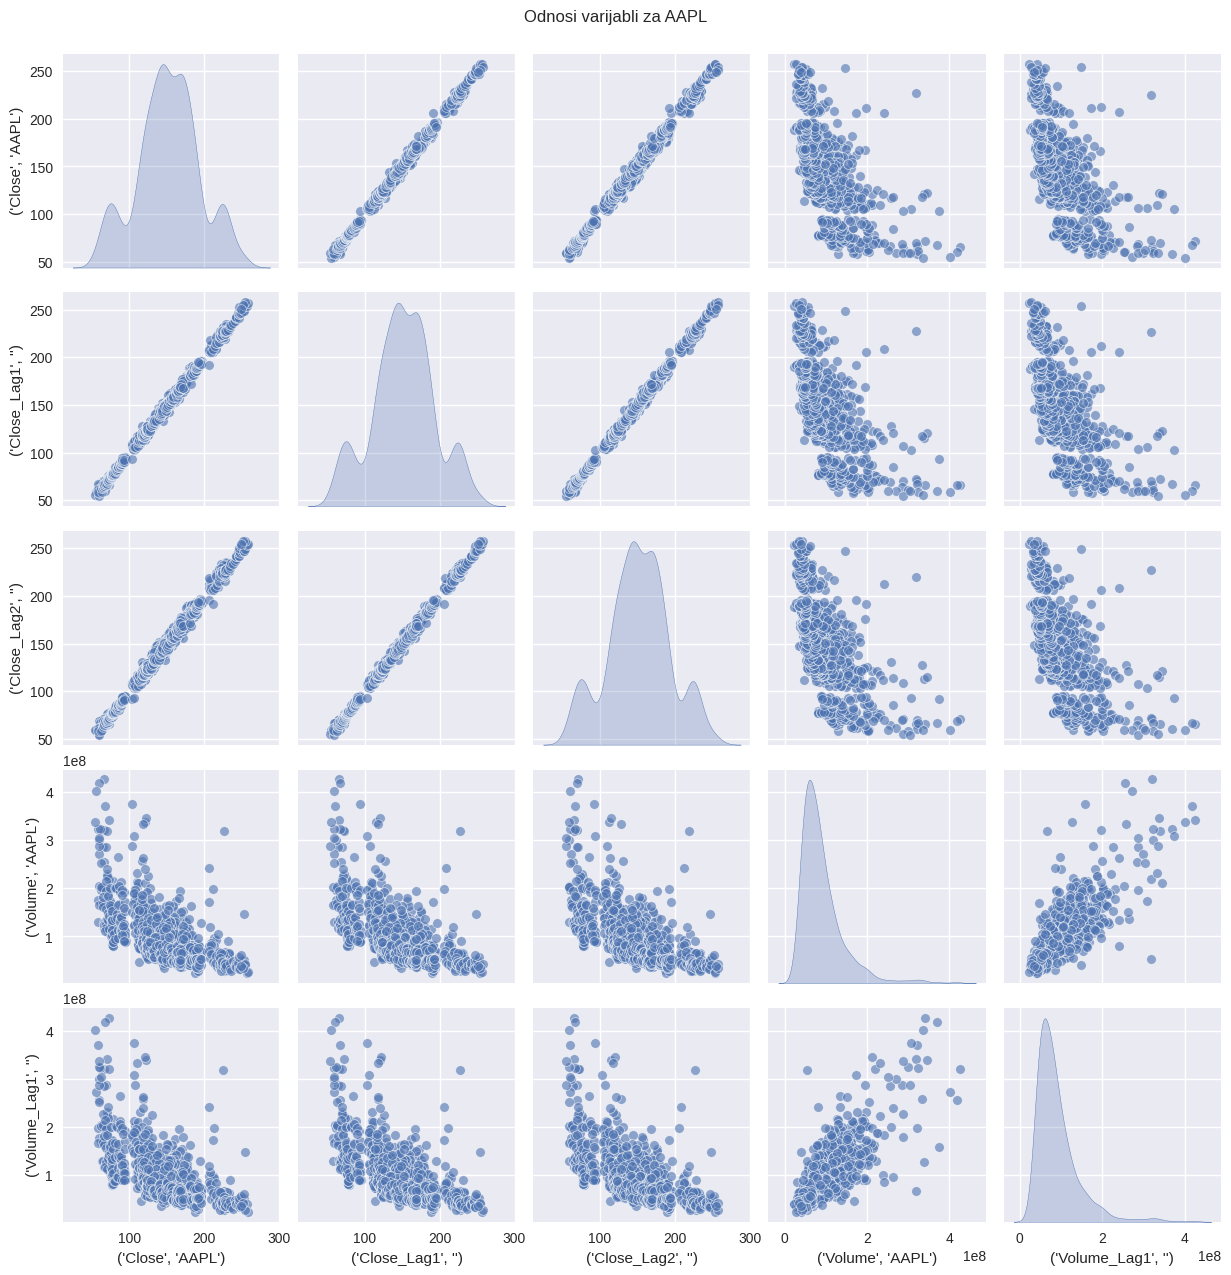

In [17]:
# 2. PAIRPLOT (Dijagrami raspršenja)
sns.pairplot(correlation_data, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle(f'Odnosi varijabli za {ticker}', y=1.02)
plt.show()

Ovaj skup grafova prikazuje odnose "svatko sa svakim".

**Gornji red (odnos prema `Close`):**
*   Kada gledamo graf **Close vs. Close_Lag1**, vidimo dijagonalnu liniju. To znači da su podaci izrazito linearni, kako raste jučerašnja cijena, raste i današnja. To je idealan scenarij za linearnu regresiju.
*   S druge strane, grafovi koji uključuju **Volume** izgledaju kao "oblak" točaka bez jasnog smjera, što vizualno potvrđuje da volumen nema jasnu linearnu vezu s cijenom u ovom vremenskom okviru.


## 3. Evaluacija Modela

Model je treniran na podacima do listopada 2023., a sada ga testiramo na novim podacima (listopad 2023. - prosinac 2024.).

Koristimo standardne regresijske metrike za ocjenu kvalitete:
*   **R² (Koeficijent determinacije):** Govori nam koliko dobro model objašnjava varijancu u podacima (bliže 1 je bolje).
*   **RMSE (Korijen srednje kvadratne pogreške):** Kažnjava veće greške više nego manje (u dolarima).
*   **MAE (Srednja apsolutna pogreška):** Prosječna greška predikcije u dolarima.
*   **MAPE (Srednja apsolutna postotna pogreška):** Prosječna greška izražena u postotku.


In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Izračun metrika
r2 = r2_score(y_test, prediction)
rmse = np.sqrt(mean_squared_error(y_test, prediction))
mae = mean_absolute_error(y_test, prediction)
mape = np.mean(np.abs((y_test - prediction) / y_test)) * 100

print("REZULTATI EVALUACIJE NA TESTNOM SETU")
print("=" * 40)
print(f"R² Score (Pouzdanost modela): {r2:.4f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:.2f}")
print(f"MAE (Mean Absolute Error):      ${mae:.2f}")
print(f"MAPE (Mean Abs % Error):        {mape:.2f}%")
print("=" * 40)

# Kratak komentar kroz kod (opcionalno)
print(f"Zaključak: Model u prosjeku griješi za oko {mape:.2f}% cijene dionice.")


REZULTATI EVALUACIJE NA TESTNOM SETU
R² Score (Pouzdanost modela): 0.9878
RMSE (Root Mean Squared Error): $2.75
MAE (Mean Absolute Error):      $2.05
MAPE (Mean Abs % Error):        1.02%
Zaključak: Model u prosjeku griješi za oko 1.02% cijene dionice.


### Vizualna usporedba: Stvarno vs. Predviđeno
Graf ispod prikazuje kretanje stvarne cijene (Plavo) i predviđene cijene (Narančasto) kroz testni period.
Obratimo pozornost na to kako model prati trend, ali s malim kašnjenjem (*lag*) kod naglih promjena smjera.


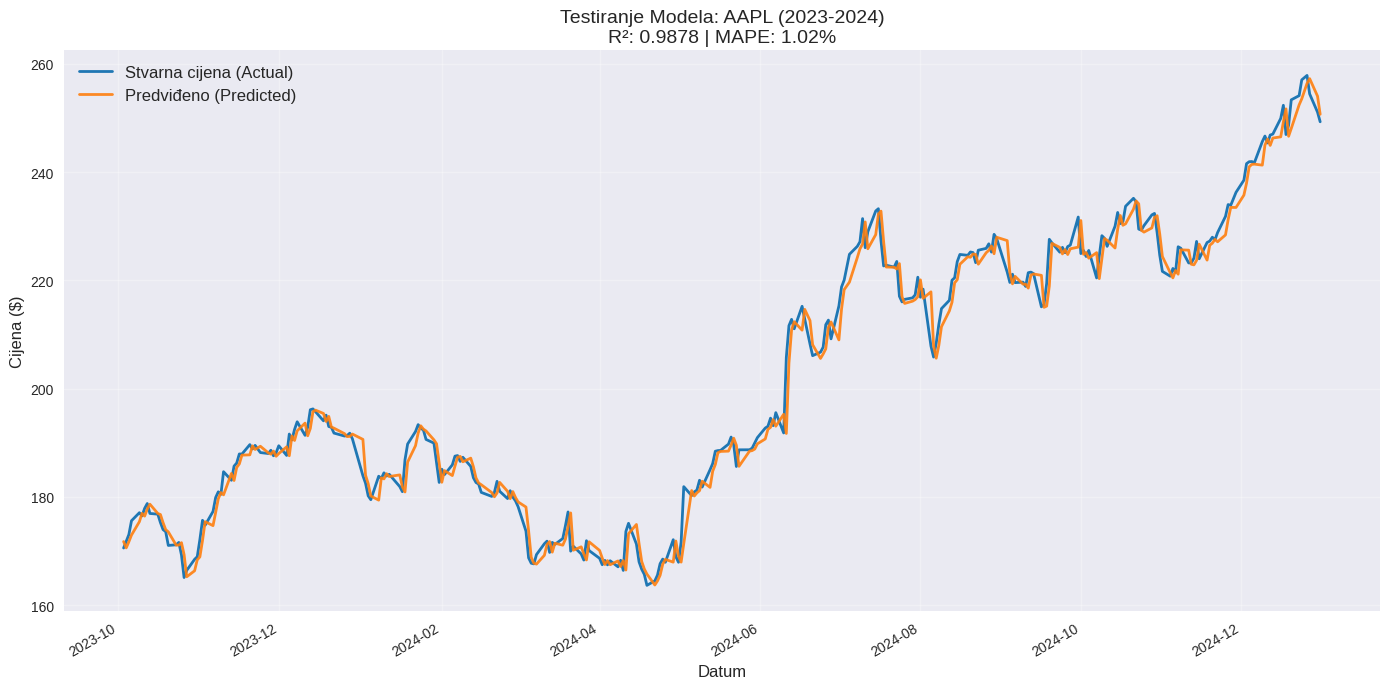

In [19]:
plot_df = pd.DataFrame(
    {"Actual": y_test, "Predicted": prediction},
    index=test_dates
).sort_index()

fig, ax = plt.subplots(figsize=(14, 7))

# Crtanje linija
ax.plot(plot_df.index, plot_df['Actual'], label="Stvarna cijena (Actual)", color="#1f77b4", linewidth=2)
ax.plot(plot_df.index, plot_df['Predicted'], label="Predviđeno (Predicted)", color="#ff7f0e", linewidth=2, alpha=0.9)

# Uređivanje grafa
ax.set_title(f"Testiranje Modela: {ticker} (2023-2024)\nR²: {r2:.4f} | MAPE: {mape:.2f}%", fontsize=14)
ax.set_xlabel("Datum", fontsize=12)
ax.set_ylabel("Cijena ($)", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Svaka 2 mjeseca
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


## 4. Analiza Značajki i Pogrešaka

Kako bismo bolje razumjeli ponašanje modela, analiziramo:
1.  **Koeficijente modela:** Koja varijabla najviše utječe na predikciju?
2.  **Najveće pogreške:** U kojim specifičnim danima je model najviše pogriješio?


In [20]:
# 1. ANALIZA ZNAČAJKI (Koeficijenti)
features = ['Close_Lag1', 'Close_Lag2', 'Volume_Lag1']
coefficients = model.coef_

coeff_df = pd.DataFrame({
    'Značajka': features,
    'Koeficijent': coefficients
})

print("\nUTJECAJ ZNAČAJKI (Koeficijenti):")
print("-" * 33)
with pd.option_context('display.float_format', '{:.10f}'.format):
    print(coeff_df)


# 2. ANALIZA NAJVEĆIH GREŠAKA
# Dodajemo stupac apsolutne greške
plot_df['AbsError'] = (plot_df['Actual'] - plot_df['Predicted']).abs()
plot_df['Error %'] = (plot_df['AbsError'] / plot_df['Actual']) * 100

# Top 5 dana s najvećom greškom
top_errors = plot_df.sort_values(by='AbsError', ascending=False).head(5)

print("\nTOP 5 DANA S NAJVEĆOM GREŠKOM:")
print("-" * 60)
print(top_errors[['Actual', 'Predicted', 'AbsError', 'Error %']])



UTJECAJ ZNAČAJKI (Koeficijenti):
---------------------------------
      Značajka   Koeficijent
0   Close_Lag1  0.9529810452
1   Close_Lag2  0.0405151674
2  Volume_Lag1 -0.0000000017

TOP 5 DANA S NAJVEĆOM GREŠKOM:
------------------------------------------------------------
                Actual   Predicted   AbsError   Error %
Date                                                   
2024-06-11  205.752518  191.719590  14.032928  6.820295
2024-05-03  181.896194  171.366898  10.529296  5.788629
2024-08-05  207.858246  217.879507  10.021261  4.821200
2024-09-19  227.589157  218.933378   8.655779  3.803248
2024-04-11  173.623642  166.496558   7.127084  4.104904


### Interpretacija i Zaključak

**1. Analiza značajki:**
Kao što vidimo iz tablice koeficijenata, **`Close_Lag1`** (cijena jučer) ima koeficijent vrlo blizu 1.0, dok su ostali koeficijenti zanemarivi. To potvrđuje da se model gotovo isključivo oslanja na zadnju poznatu cijenu, što je karakteristično za jednostavne autoregresijske modele ("Naive Forecast").

**2. Gdje model griješi?**
Model najviše griješi u danima visoke volatilnosti (vidi tablicu "TOP 5 DANA S NAJVEĆOM GREŠKOM:"). To su obično datumi kada:
*   Tvrtka objavljuje financijska izvješća (Earnings reports).
*   Dolazi do naglih makroekonomskih vijesti.
Budući da model ne "vidi" vijesti, on reagira tek dan kasnije, što rezultira većom greškom u trenutku skoka/pada.

**3. Je li model dobar?**
Model je **statistički vrlo precizan** (MAPE ~1%) i koristan za praćenje trenda u stabilnim uvjetima. Međutim, njegova sposobnost *anticipiranja* promjena je ograničena. Za potrebe web aplikacije koja prikazuje trendove, model je zadovoljavajuć, ali nije dovoljan za automatizirano trgovanje visokog rizika.
